In [1]:
# Loading the dataset
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:

!kaggle datasets download -d alsaniipe/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/flowers-dataset
License(s): CC0-1.0
 79% 48.0M/60.5M [00:00<00:00, 139MB/s]
100% 60.5M/60.5M [00:00<00:00, 139MB/s]


In [3]:
!unzip flowers-dataset.zip -d flowers-dataset


Archive:  flowers-dataset.zip
  inflating: flowers-dataset/README.dataset.txt  
  inflating: flowers-dataset/README.roboflow.txt  
  inflating: flowers-dataset/test/daisy/10466290366_cc72e33532_jpg.rf.6ddc91cd5d4a6a683e567ccb37e5a089.jpg  
  inflating: flowers-dataset/test/daisy/10466558316_a7198b87e2_jpg.rf.7acf642b94dc98daa49482a12994ac4c.jpg  
  inflating: flowers-dataset/test/daisy/12193032636_b50ae7db35_n_jpg.rf.e6c4eeb71c56e793a0d85f6d979dbe20.jpg  
  inflating: flowers-dataset/test/daisy/1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg  
  inflating: flowers-dataset/test/daisy/1354396826_2868631432_m_jpg.rf.409eee37613d16dbc71365cb5615327e.jpg  
  inflating: flowers-dataset/test/daisy/1374193928_a52320eafa_jpg.rf.e398f632151f3ccc5729bc89527d7614.jpg  
  inflating: flowers-dataset/test/daisy/1392131677_116ec04751_jpg.rf.da99f9bb579ee96dc1728545ca519d6f.jpg  
  inflating: flowers-dataset/test/daisy/14333681205_a07c9f1752_m_jpg.rf.6ff96d9fe33f0bd19a18425f32d470b1.j

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
train_dir = '/content/flowers-dataset/train'
test_dir = '/content/flowers-dataset/test'

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_datasets = {x: datasets.ImageFolder(os.path.join(train_dir if x == 'train' else test_dir),
                                         train_transforms if x == 'train' else test_transforms)
                  for x in ['train', 'test']}


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 1275, 'test': 182}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


['daisy', 'dandelion']

In [8]:
model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    if "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.4MB/s]


In [9]:

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.8343 Acc: 0.7145
test Loss: 0.3382 Acc: 0.8297
train Loss: 0.5439 Acc: 0.7929
test Loss: 0.2550 Acc: 0.8791
train Loss: 0.4847 Acc: 0.8063
test Loss: 0.2998 Acc: 0.8736
train Loss: 0.4545 Acc: 0.8251
test Loss: 0.2048 Acc: 0.9286
train Loss: 0.5110 Acc: 0.8110
test Loss: 0.5433 Acc: 0.8352
train Loss: 0.5880 Acc: 0.7851
test Loss: 0.1812 Acc: 0.9286
train Loss: 0.4930 Acc: 0.8024
test Loss: 0.2411 Acc: 0.9066
train Loss: 0.5236 Acc: 0.8024
test Loss: 0.1904 Acc: 0.9066
train Loss: 0.4876 Acc: 0.8102
test Loss: 0.2157 Acc: 0.9011
train Loss: 0.4757 Acc: 0.8141
test Loss: 0.1865 Acc: 0.9121
Training complete!


In [10]:
# Save the model
torch.save(model.state_dict(), 'flower_classification_model.pth')

# Classification on New Image

**To use the saved model to classify new images, you need to load the model and then apply it to the new images, so we load the model..**

In [11]:
import torch
from torchvision import models, transforms
from PIL import Image


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()


new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)


new_model.fc.weight.data = model.fc.weight.data[0:2]
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [13]:
image_path = '/content/daisy.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [14]:
with torch.no_grad():
    output = model(input_batch)


_, predicted_class = output.max(1)


class_names = ['daisy', 'dandelion']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: daisy


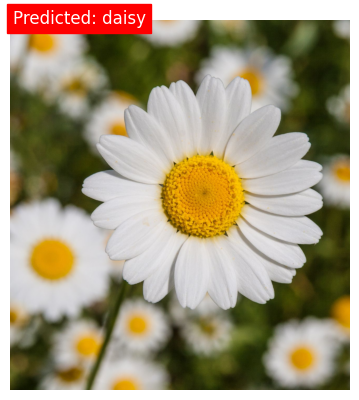

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [16]:
image_path = '/content/dandelion.jpeg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [17]:
with torch.no_grad():
    output = model(input_batch)


_, predicted_class = output.max(1)


class_names = ['daisy', 'dandelion']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: dandelion


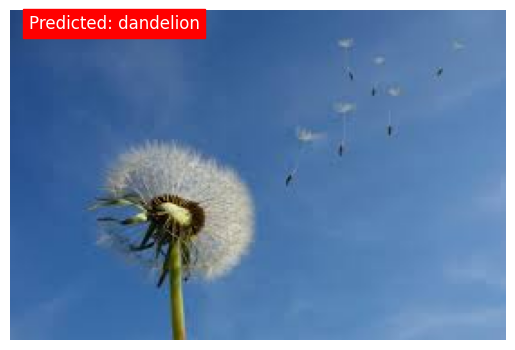

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()